In [7]:
import csv
import torch
import torchvision
from torchvision.transforms import ToPILImage, Normalize, ToTensor
from PIL import Image
import cv2

import numpy as np
import matplotlib.pyplot as plt

from seg import TSCNet

In [2]:
"""
Function that splits the image data into different file (for training, 
val, and testing)
@param: k 
@param k1
@param image_dir
"""
def get_k_fold_data(k, k1, image_dir):
    assert k > 1
    # if k1==0:#第一次需要打开文件

    file = open(image_dir, 'r', encoding='utf-8')
    reader=csv.reader(file)
    imgs_ls = []
    for line in file.readlines():
        imgs_ls.append(line)
    file.close()

    train_num = int(len(imgs_ls) * 0.1)
    avg = len(imgs_ls) // k 
    f1 = open('result/kfold_5/seg_train_' + str(k1) + '.txt', 'w+')
    f2 = open('result/kfold_5/seg_val_'+str(k1)+'.txt', 'w+')
    f3 = open('result/kfold_5/seg_test_' + str(k1) + '.txt', 'w+')
    total=[]
    for i, row in enumerate(imgs_ls):
        # print(row)
        if (i // avg) == k1:   #1-5
            f3.writelines(row)

        else:
            total.append(row)

    train_num = int(len(imgs_ls) * 0.1)
    for i, row in enumerate(total[:train_num]):
        f2.writelines(row)

    for i, row in enumerate(total[train_num:]):
        f1.writelines(row)

    f1.close()
    f2.close()
    f3.close()

In [3]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, is_train,root):
        super(MyDataset, self).__init__()
        fh = open(root, 'r', encoding="utf-8")
        imgs = []  # 创建一个名为img的空列表，一会儿用来装东西
        for line in fh: 
            line = line.rstrip() 
            words = line.split()
            imgs.append((words[0], words[1]))
        # random.shuffle(imgs)
        self.imgs = imgs
        self.is_train = is_train
        if self.is_train:
            self.train_tsf = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.443, 0.354, 0.326], std=[0.183, 0.178, 0.167]),
            ])
            self.train_lable = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
            ])
        else:
            self.test_tsf = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.443, 0.354, 0.326], std=[0.183, 0.178, 0.167]),
            ])
            self.test_lable = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
            ])

    def __getitem__(self, index):  
        feature, label = self.imgs[index]  # fn是图片path #fn和label分别获得imgs[index]也即是刚才每行中word[0]和word[1]的信息
        path = label
        feature = cv2.imread(feature)
        label = cv2.imread(label, 0)
        # print(label.shape)
        if self.is_train:
            feature = self.train_tsf(feature)
            label = self.train_lable(label)
        else:
            feature = self.test_tsf(feature)
            label = self.test_lable(label)

        return feature, label, path

    def __len__(self):
        return len(self.imgs)

In [5]:
batch_size = 2
train_k = 'result/kfold_5/seg_train_' + str(1) + '.txt'
val_k = 'result/kfold_5/seg_val_' + str(1) + '.txt'
train_data = MyDataset(is_train=True, root=train_k)
val_data = MyDataset(is_train=False, root=val_k)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [13]:
for i, (input, target, path) in enumerate(train_loader):
    curInput = input
    curTarget = target
    print(path)
    break

('data/mask_new/76.jpg', 'data/mask_new/258.jpg')


In [14]:
curInput.size()

torch.Size([2, 3, 576, 768])

In [27]:
tesnor2img = ToPILImage()
img = tesnor2img(curTarget[0])
# img = img.convert("RGB")

In [30]:
img.save("curImage.jpg")

In [44]:
ckpt = torch.load("best_model/fold_3_2.pth")
mappings = {k:k.split(".", 1)[1] for k in ckpt.keys()}
ckpt = {mappings[k]:v for k, v in ckpt.items()}

net = TSCNet.TSCUNet(3,1)
net.load_state_dict(ckpt)
net.eval()

TSCUNet(
  (conv1): DoubleConv2_1(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), dilation=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): DoubleConv2_2(
    (conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): DoubleConv2_3(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): DoubleConv2_3(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3)

In [46]:
for name, param in net.named_parameters():
    # check if the dict is loaded
    print(name, param.data)
    break

conv1.conv.0.weight tensor([[[[ 0.0952, -0.0648,  0.1758],
          [ 0.1055, -0.0278,  0.0967],
          [-0.0020, -0.1749,  0.0949]],

         [[ 0.1475,  0.0384,  0.0803],
          [ 0.0557, -0.1911,  0.1391],
          [-0.1858, -0.1584, -0.0578]],

         [[-0.0122, -0.0669,  0.1109],
          [ 0.0260,  0.0197, -0.1230],
          [ 0.0442, -0.0626, -0.1311]]],


        [[[ 0.0233, -0.0838,  0.1384],
          [-0.1193,  0.1168,  0.1530],
          [ 0.1573, -0.1396,  0.1210]],

         [[ 0.0551, -0.0971,  0.0892],
          [-0.1455, -0.0619,  0.0085],
          [ 0.1622,  0.1556,  0.0203]],

         [[ 0.1420, -0.1061, -0.0721],
          [-0.0712, -0.1394,  0.0241],
          [-0.1734, -0.1183,  0.0849]]],


        [[[ 0.1145, -0.0205,  0.0206],
          [-0.0067,  0.0295,  0.0155],
          [ 0.0031,  0.0335,  0.0907]],

         [[-0.0623,  0.1612,  0.0392],
          [-0.0364, -0.0600,  0.1645],
          [ 0.0151,  0.0346,  0.0286]],

         [[ 0.1148, -0.1

In [47]:
curInput.size()

torch.Size([2, 3, 576, 768])

In [51]:
predCurInput = net(curInput)
predImg = tesnor2img(predCurInput[0])
predImg.save("curPredImage.jpg")

## Do it for random batches in validation set

In [57]:
import random

In [55]:
len(val_loader)

30

In [58]:
numbers = range(30)
sample = random.sample(numbers, 5)
sample

[27, 26, 5, 11, 14]

In [59]:
for i, (input, target, path) in enumerate(val_loader):
    if i in sample:
        curInput = input
        curTarget = target
        predCurInput = net(curInput)
        img = tesnor2img(curTarget[0])
        predImg = tesnor2img(predCurInput[0])
        saveName = path[0].split('/')[-1]
        saveDir = "./result/saved_predict/"
        img.save(saveDir+"gt"+saveName)
        predImg.save(saveDir+"pred"+saveName)
    # print(path)
    # break

## Denoise

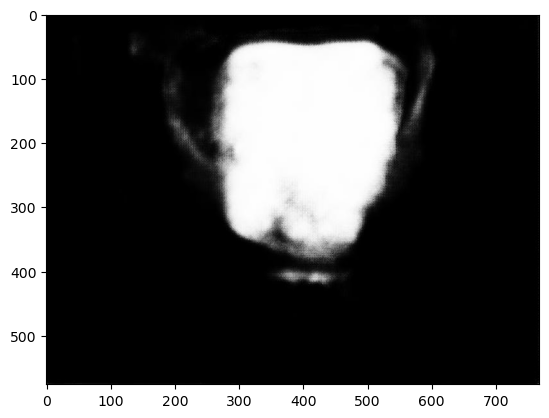

In [8]:
img = cv2.imread("result/saved_predict/pred11.jpg")
plt.imshow(img)

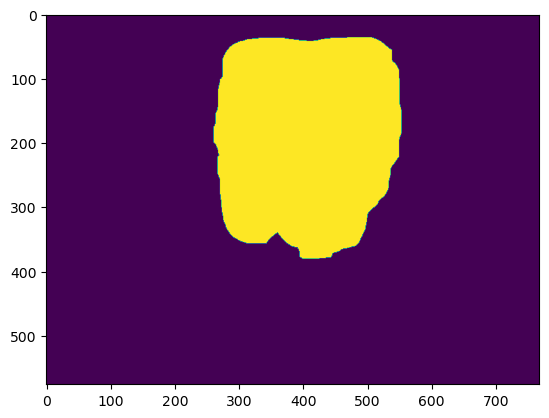

In [18]:
kernel = np.ones((5, 5), np.uint8)
img_gray = cv2.imread("result/saved_predict/pred11.jpg", cv2.IMREAD_GRAYSCALE)
img_med = cv2.medianBlur(img_gray, ksize=7)
img_erod = cv2.erode(img_med, kernel, iterations=3)
img_dilate = cv2.dilate(img_erod, kernel, iterations=3)
ret, img_threshold = cv2.threshold(img_dilate, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
img_mask = cv2.dilate(img_threshold, kernel, iterations=3)

# _, contours, _ = cv2.findContours(img_dilate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
# img_contours = cv2.drawContours(img_rgb, contours, -1, (0,0,255))

plt.imshow(img_mask)

In [21]:
cv2.imwrite("./result/saved_predict/denoise11.jpg", img_mask)

# img_mask.save("./result/saved_predict/denoise11.jpg")

True